In [99]:
import pandas as pd 
from pandas.api.types import CategoricalDtype

import numpy as np 
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt


import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [100]:
house_data = pd.read_csv('data/kc_house_data.csv')

test_data = house_data[['id', 'bedrooms', 'bathrooms', 'sqft_living', 'floors',
                        'condition','grade', 'yr_built', 'zipcode', 'view', 'price'
                       ]].copy()

# Drop duplicates 
test_data.drop_duplicates(subset= 'id', keep='first', inplace=True, ignore_index = True)

# bedrooms drop all greater than 6
test_data.drop(test_data.index[test_data['bedrooms'] >= 7], inplace = True) # ---- UNDO

#bathrooms remove all nulls
test_data['bathrooms'] = test_data['bathrooms'].dropna()

# Price drop outliers 
test_data['price'] = test_data['price'].map(lambda x: np.log(x)) 

# Waterfront drop nulls 
house_data = house_data[house_data['waterfront'].notna()]

# View dropna
test_data = test_data[test_data['view'].notna()]

# grade drop single low value
test_data = test_data[test_data['grade'] != '3 Poor']
# **************************************************************************************
# ABOVE IS GOOD 

In [101]:
# Map values 0-1 to ordinal categorical
test_data.condition.replace({'Poor':0.2, 'Fair': 0.4, 'Average':0.6, 'Good':0.8, 'Very Good': 1.0}, inplace = True)

test_data.grade.replace({'4 Low': 0.1, '5 Fair':0.2, '6 Low Average':0.3, '7 Average':0.4,'8 Good':0.5,
                 '9 Better':0.6, '10 Very Good':0.7, '11 Excellent':0.8,'12 Luxury':0.9, 
                 '13 Mansion':1.0}, inplace = True)

In [102]:
ord_cat_selector = ['view'] # ----for testin
cat_subset = test_data[ord_cat_selector]
ordered_view = ['NONE', 'AVERAGE', 'GOOD', 'FAIR', 'EXCELLENT']
o_enc = OrdinalEncoder(categories = [ordered_view]) # --- original
o_enc.fit(cat_subset)
X_subset = pd.DataFrame(o_enc.transform(cat_subset),
                       columns = cat_subset.columns)

In [103]:
# Predict price
nom_features = ['bathrooms','price', 'sqft_living', 'grade', 'bedrooms'] # ---TEST
# bedrooms, yearBuilt, grade, sqft, price,


dum_zipcode = pd.get_dummies(test_data['zipcode'], prefix = 'zip', drop_first = True)
dum_year = pd.get_dummies(test_data['yr_built'], prefix = 'year', drop_first = True)

X_p = pd.concat([test_data[nom_features], dum_year, dum_zipcode],join = 'inner', axis = 1) 


X = X_p.drop(columns = 'price')
y = X_p['price']

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y, test_size=0.3)

In [104]:
# Fit price print values R Score =  0.831
lr_p = LinearRegression()
lr_p.fit(X_train_p, y_train_p)
y_pred_p = lr_p.predict(X_test_p)
R_p = lr_p.score(X_train_p, y_train_p)
MAE_p = mean_absolute_error(np.exp(y_pred_p), np.exp(y_test_p))
RMSE_p = np.sqrt(mean_squared_error(np.exp(y_pred_p), np.exp(y_test_p)))
print('Price Prediction:' '\n' 'R Score = ', R_p, '\n' 'MAE = ', MAE_p,
      '\n' 'RMSE = ', RMSE_p, '\n' 'First five predicted values : ', y_pred_p[0:5])

Price Prediction:
R Score =  0.8541185703876202 
MAE =  87229.88013804567 
RMSE =  230126.52055469854 
First five predicted values :  [13.71041266 13.44332103 12.61212743 12.86934969 12.83518496]


In [105]:
# Predict grade
nom_features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors',
                 'price', 'grade'] #test--- R Score =  0.757

dum_zipcode = pd.get_dummies(test_data['zipcode'], prefix = 'zip', drop_first = True)
dum_year = pd.get_dummies(test_data['yr_built'], prefix = 'year', drop_first = True)
X_ = pd.concat([test_data[nom_features], X_subset, dum_year, dum_zipcode],join = 'inner', axis = 1) #-- original

X = X_.drop(columns = 'grade')
y = X_['grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [106]:
# Fit grade print Values R Score =  0.749
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
R = lr.score(X_train, y_train)
MAE = mean_absolute_error(y_pred, y_test)
RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
COEF = lr.coef_
print('Grade Prediction:' '\n' 'R Score = ', R, '\n' 'MAE = ', MAE, '\n' 'RMSE = ', RMSE, '\n' 
      'First five predicted values : ', y_pred[0:5])

Grade Prediction:
R Score =  0.7520994697001449 
MAE =  0.045608484983429474 
RMSE =  0.05791682098208696 
First five predicted values :  [0.32064962 0.39652942 0.50683479 0.43789628 0.4419165 ]


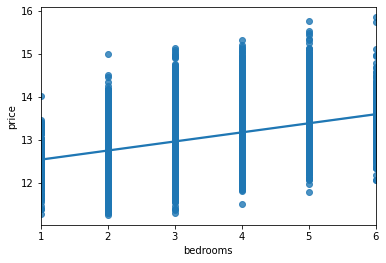

In [107]:
sns.regplot(test_data.bedrooms,test_data.price, fit_reg = True);

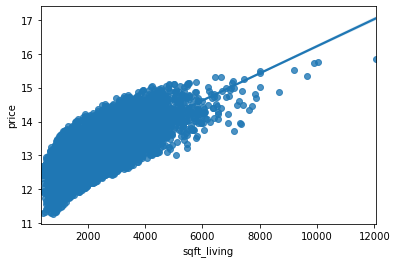

In [108]:
sns.regplot(test_data.sqft_living,test_data.price, fit_reg = True);

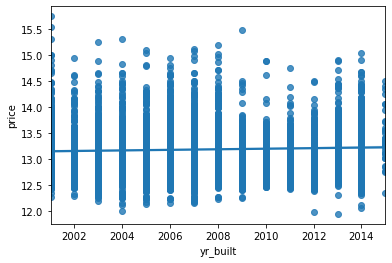

In [109]:
sns.regplot(test_data['yr_built'].loc[test_data.yr_built > 2000],
            test_data['price'].loc[test_data.yr_built > 2000], fit_reg = True);

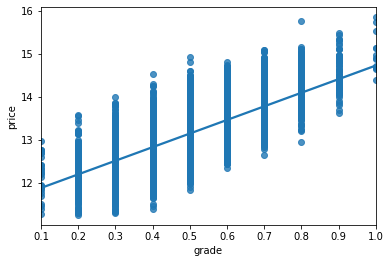

In [110]:
sns.regplot(test_data.grade, test_data.price, fit_reg = True);

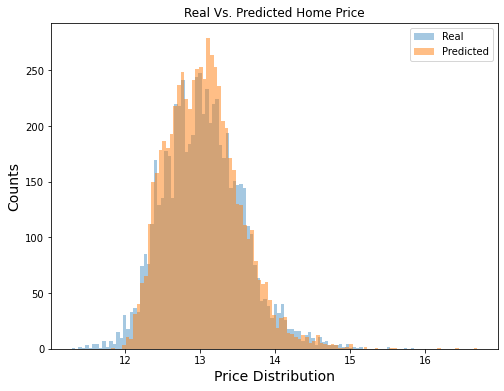

In [111]:
plt.figure(figsize=(8,6))
plt.hist(y_test_p, bins=100, alpha=0.4, label="Real")
plt.hist(y_pred_p, bins=100, alpha=0.5, label="Predicted")
plt.xlabel("Price Distribution", size=14)
plt.ylabel("Counts", size=14)
plt.title("Real Vs. Predicted Home Price")
plt.legend(loc='upper right');

In [137]:
bedrooms = pd.Series(test_data.bedrooms , name = 'bedrooms')
yearBuilt = pd.Series(test_data['yr_built'].loc[test_data.yr_built > 2000] , name = 'year_built')
grade = pd.Series(test_data['grade'].loc[test_data.grade >= 0.5], name = 'grade')
sqft = pd.Series(test_data['sqft_living'].loc[test_data.sqft_living > 2000] , name = 'sqft')
price = pd.Series(test_data['price'], name = 'price')

# combi_df = pd.concat([bedrooms, yearBuilt, grade, sqft, price],join = 'inner', axis = 1) 
combi_df = pd.concat([bedrooms, yearBuilt, grade, sqft, price, dum_year, dum_zipcode],join = 'inner', axis = 1) 


X = combi_df.drop(columns = 'price')
y = combi_df['price']

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y, test_size=0.3)

In [138]:
lr_p = LinearRegression()
lr_p.fit(X_train_p, y_train_p)
y_pred_p = lr_p.predict(X_test_p)
R_p = lr_p.score(X_train_p, y_train_p)
MAE_p = mean_absolute_error(np.exp(y_pred_p), np.exp(y_test_p))
RMSE_p = np.sqrt(mean_squared_error(np.exp(y_pred_p), np.exp(y_test_p)))
print('Price Prediction:' '\n' 'R Score = ', R_p, '\n' 'MAE = ', MAE_p,
      '\n' 'RMSE = ', RMSE_p, '\n' 'First five predicted values : ', y_pred_p[0:5])

Price Prediction:
R Score =  0.8930938605828236 
MAE =  103557.1597156115 
RMSE =  209067.6764541633 
First five predicted values :  [13.4164972  14.44148567 13.37523174 12.68475932 13.07365185]


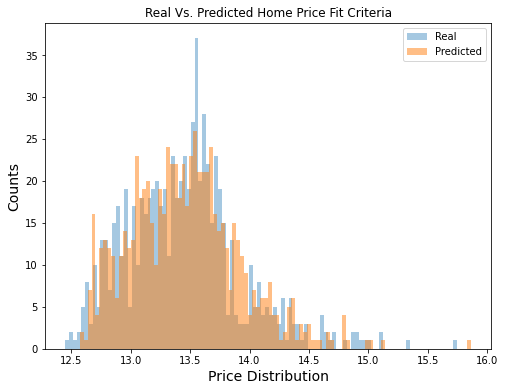

In [139]:
plt.figure(figsize=(8,6))
plt.hist(y_test_p, bins=100, alpha=0.4, label="Real")
plt.hist(y_pred_p, bins=100, alpha=0.5, label="Predicted")
plt.xlabel("Price Distribution", size=14)
plt.ylabel("Counts", size=14)
plt.title("Real Vs. Predicted Home Price Fit Criteria")
plt.legend(loc='upper right');

In [142]:
Mean_Predicted_price = np.exp(y_pred_p.mean())
Mean_Predicted_price

696830.0327731646